# 1. Setup and Installation

## Create virtual environment

```shell
python3 -m venv .venv
```

## Activate virtual environment:

```shell
source .venv/bin/activate
```

## Install the project dependencies

```shell
pip install -r requirements.txt
```

## Download spacy en core web sm
```shell
python -m spacy download en_core_web_sm
```

## Create util folders

In the root of the project, create the folders `cleaned_texts` and  `pdfs`


## Download the file to analyze

Download the file [PND_2025-2030_v250226_14.pdf](https://drive.google.com/file/d/1O20jR5Bdkof1lZuXCuutjvaUlnDOuG70/view?usp=sharing) and save it into the `pdfs/` folder.

# 2. Import the libraries.

In [1]:
import os
import re
import PyPDF2 # For basic PDF reading
import pdfplumber # For more robust text extraction, especially with layouts
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# Download necessary NLTK data (if not already downloaded)
# Note: Catching LookupError is generally more robust for nltk.data.find
try:
    nltk.data.find('corpora/stopwords')
except LookupError: # Catch LookupError as per NLTK's output
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

try:
    nltk.data.find('corpora/wordnet')
except LookupError: # THIS IS THE FIX FOR YOUR SPECIFIC ERROR
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/brown') # For some readability metrics
except LookupError:
    nltk.download('brown')

[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Configuration

In [2]:
# Define the folder where your PDF files are located
PDF_FOLDER = 'pdfs' # Create a folder named 'pdfs' in the same directory as this notebook
CLEANED_TEXT_FOLDER = 'cleaned_texts' # Folder to store cleaned text files
COMBINED_CLEANED_TEXT_FILE = os.path.join(CLEANED_TEXT_FOLDER, 'combined_cleaned_text.txt')

# Language of the analyzed text
LANGUAGE = 'spanish'
# Create folders if they don't exist
os.makedirs(PDF_FOLDER, exist_ok=True)
os.makedirs(CLEANED_TEXT_FOLDER, exist_ok=True)

# 4. PDF Extraction and Cleaning

This section handles reading multiple PDF files, extracting their text, and cleaning it. The cleaned text from all PDFs will be combined into a single .txt file for further analysis.

In [3]:
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a single PDF file using pdfplumber for better accuracy.
    """
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
    return text

def clean_text(text):
    """
    Cleans the extracted text by removing extra whitespaces, special characters,
    and converting to lowercase.
    """
    if not text:
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple whitespaces with a single space
    if LANGUAGE == 'spanish':
        text  = re.sub(r'[^a-z0-9\s.,;\'"-áéíóúüñ]', '', text)
    else:
        text = re.sub(r'[^a-z0-9\s.,;\'"-]', '', text) # Keep alphanumeric, spaces, and common punctuation
    text = text.strip()  # Remove leading/trailing whitespaces
    return text

def process_pdfs_pipeline(pdf_folder, cleaned_text_folder, combined_output_file):
    """
    Pipeline to read multiple PDFs, extract, clean, and store text.
    Combines all cleaned text into a single file.
    """
    all_cleaned_text = []
    for filename in os.listdir(pdf_folder):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, filename)
            print(f"Processing {filename}...")
            extracted_text = extract_text_from_pdf(pdf_path)
            cleaned_txt = clean_text(extracted_text)

            # Store individual cleaned text files (optional, but good for debugging)
            output_txt_filename = os.path.splitext(filename)[0] + ".txt"
            output_txt_path = os.path.join(cleaned_text_folder, output_txt_filename)
            with open(output_txt_path, 'w', encoding='utf-8') as f:
                f.write(cleaned_txt)
            print(f"Cleaned text saved to {output_txt_path}")

            all_cleaned_text.append(cleaned_txt)

    # Combine all cleaned texts into a single file
    with open(combined_output_file, 'w', encoding='utf-8') as f:
        f.write("\n".join(all_cleaned_text))
    print(f"\nAll cleaned text combined into {combined_output_file}")

# Run the PDF processing pipeline
# Before running, make sure you have some PDF files in the 'pdfs' folder
process_pdfs_pipeline(PDF_FOLDER, CLEANED_TEXT_FOLDER, COMBINED_CLEANED_TEXT_FILE)

# Read the combined cleaned text for further analysis
with open(COMBINED_CLEANED_TEXT_FILE, 'r', encoding='utf-8') as f:
    combined_text = f.read()

# Tokenize the combined text for common use in subsequent analyses
words = word_tokenize(combined_text)
sentences = sent_tokenize(combined_text)
if LANGUAGE == 'spanish':
    stop_words = set(stopwords.words('spanish'))
else:
    stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

Processing PND_2025-2030_v250226_14.pdf...
Cleaned text saved to cleaned_texts/PND_2025-2030_v250226_14.txt

All cleaned text combined into cleaned_texts/combined_cleaned_text.txt


# 5. Data Exploration Tasks

Now that we have our cleaned and combined text, we can perform various linguistic analyses.

## 5.1 Word Frequency Lists
Analyzes the most frequent words in the text.


--- Word Frequency List ---
estrategia: 261
desarrollo: 255
nacional: 249
mujeres: 184
méxico: 174
acceso: 174
derechos: 157
garantizar: 147
personas: 143
fortalecer: 134
social: 133
objetivo: 130
servicios: 128
bienestar: 126
mide: 121
porcentaje: 118
población: 117
país: 116
indígenas: 113
salud: 105


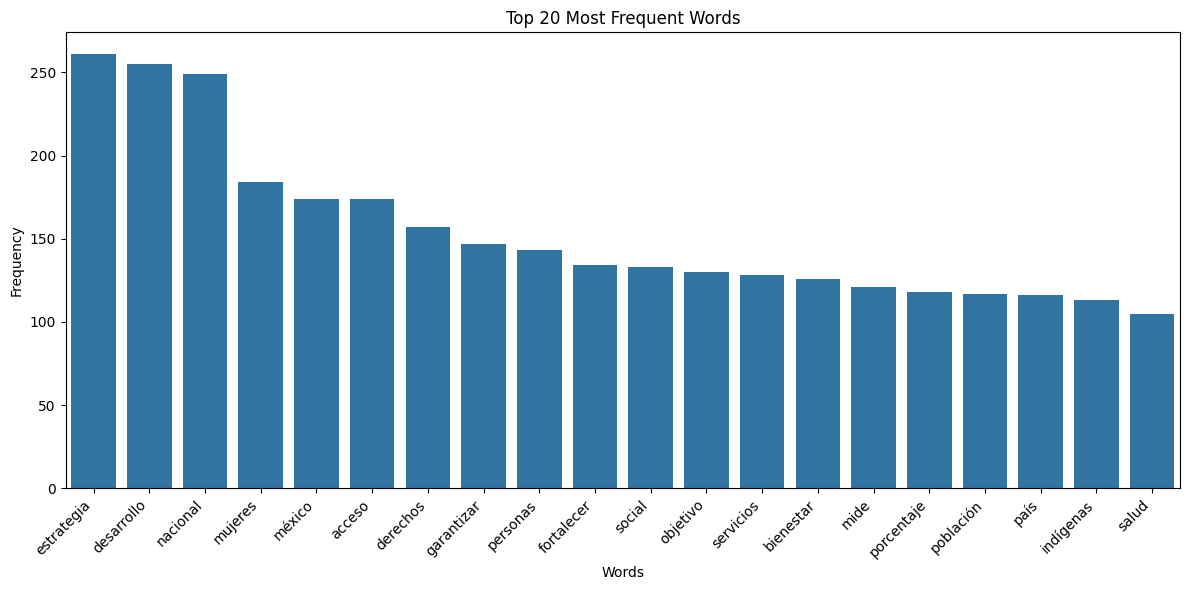

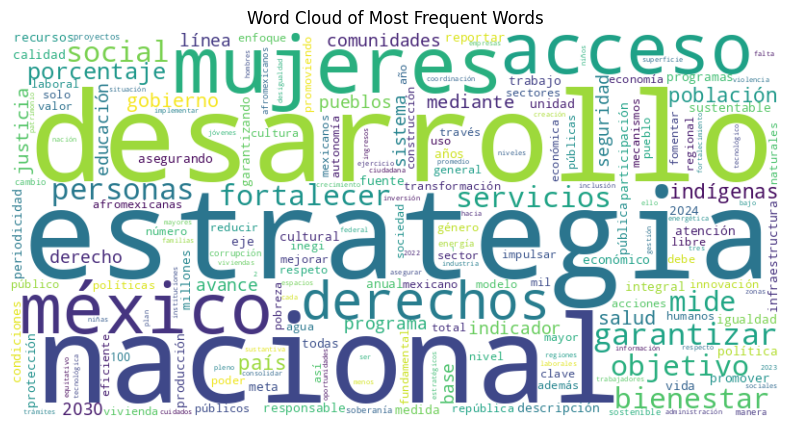

In [4]:
# Word Frequency
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(20)

print("\n--- Word Frequency List ---")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# Visualization: Bar Chart of Word Frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, freq in most_common_words], y=[freq for word, freq in most_common_words])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization: Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

## 5.2 N-gram Frequency
Analyzes the frequency of sequences of words (N-grams).


--- Bigram Frequency List ---
línea base: 70
base meta: 67
unidad medida: 66
responsable reportar: 66
reportar avance: 66
indígenas afromexicanas: 54
periodicidad anual: 54
comunidades indígenas: 53
anual línea: 53
descripción mide: 46
estrategia fortalecer: 38
medida porcentaje: 38
porcentaje periodicidad: 38
meta 2024: 36
2024 2030: 36
derechos humanos: 35
pueblos indígenas: 34
inegi responsable: 34
indígenas afromexicanos: 33
pueblos comunidades: 33

--- Trigram Frequency List ---
línea base meta: 66
responsable reportar avance: 66
periodicidad anual línea: 53
anual línea base: 53
comunidades indígenas afromexicanas: 46
unidad medida porcentaje: 38
medida porcentaje periodicidad: 38
base meta 2024: 36
meta 2024 2030: 36
inegi responsable reportar: 34
pueblos comunidades indígenas: 33
porcentaje periodicidad anual: 30
pueblos indígenas afromexicanos: 24
base meta 2022: 15
meta 2022 2030: 15
sujetos derecho público: 14
descripción mide porcentaje: 13
base meta 2023: 13
meta 2023 2030

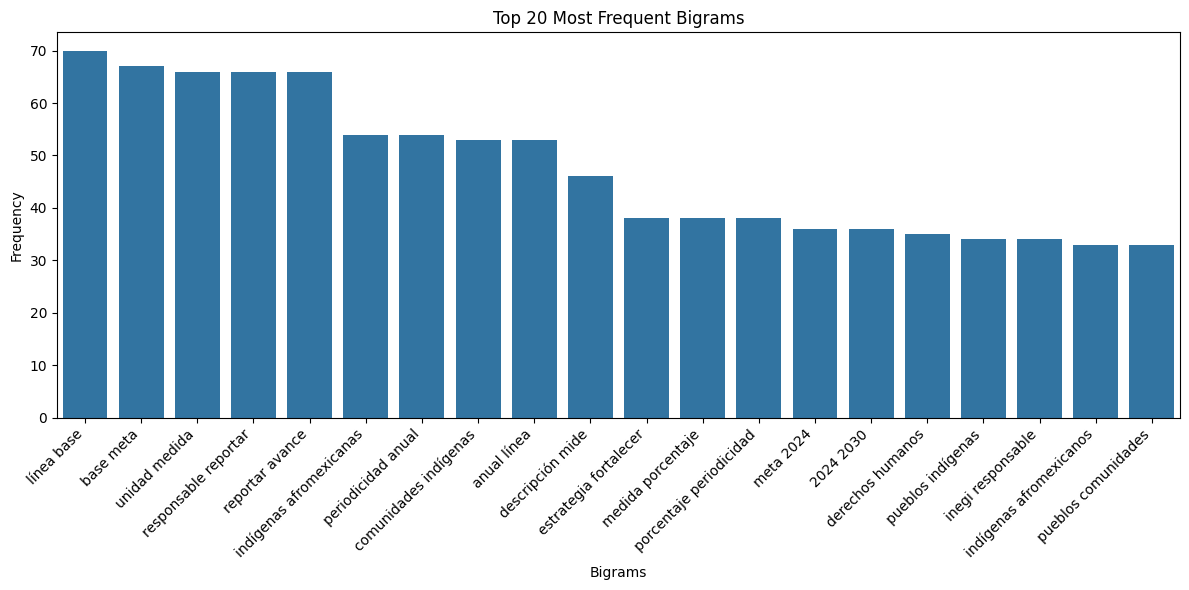

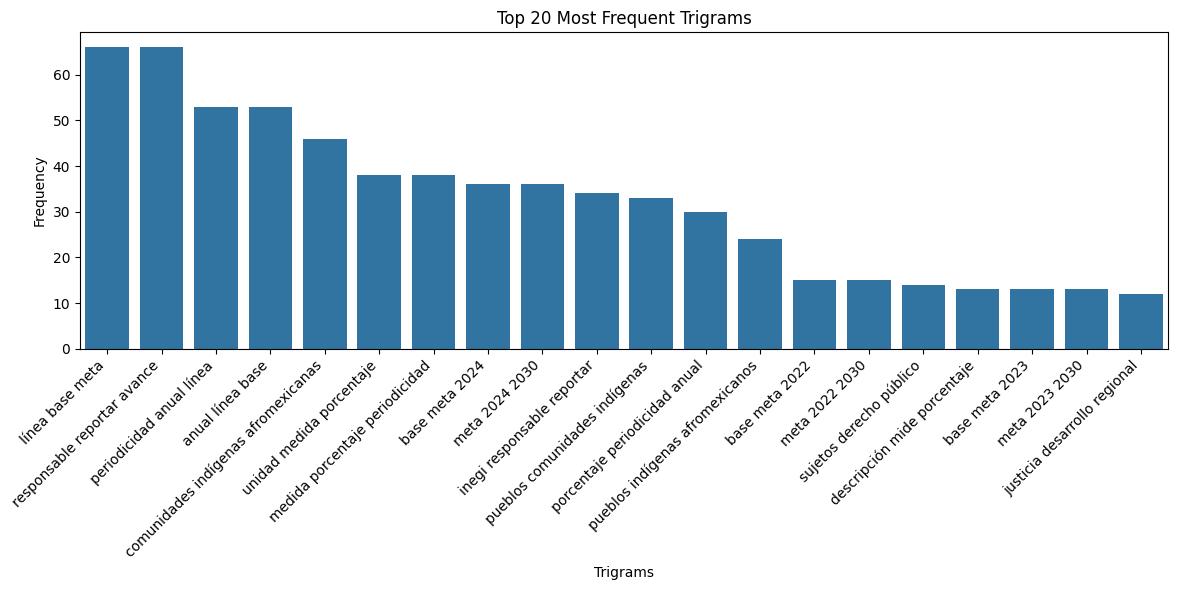

In [5]:
# N-gram Frequency (Bigrams and Trigrams)
# Bigrams
bigrams = list(ngrams(filtered_words, 2))
bigram_freq = Counter(bigrams)
most_common_bigrams = bigram_freq.most_common(20)

print("\n--- Bigram Frequency List ---")
for bigram, freq in most_common_bigrams:
    print(f"{' '.join(bigram)}: {freq}")

# Trigrams
trigrams = list(ngrams(filtered_words, 3))
trigram_freq = Counter(trigrams)
most_common_trigrams = trigram_freq.most_common(20)

print("\n--- Trigram Frequency List ---")
for trigram, freq in most_common_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

# Visualization: Bar Chart of Top 20 Bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(bigram) for bigram, freq in most_common_bigrams], y=[freq for bigram, freq in most_common_bigrams])
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization: Bar Chart of Top 20 Trigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(trigram) for trigram, freq in most_common_trigrams], y=[freq for trigram, freq in most_common_trigrams])
plt.title('Top 20 Most Frequent Trigrams')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.3 Part-of-Speech (POS) Tag Frequency

Identifies and counts the frequency of different grammatical categories (e.g., nouns, verbs, adjectives).



--- Part-of-Speech Tag Frequency ---
NN: 17813
FW: 11570
JJ: 6719
NNS: 2790
,: 2563
IN: 2106
.: 2078
CD: 1630
VBP: 1495
DT: 945
:: 743
VBZ: 605
CC: 468
RB: 321
VB: 283


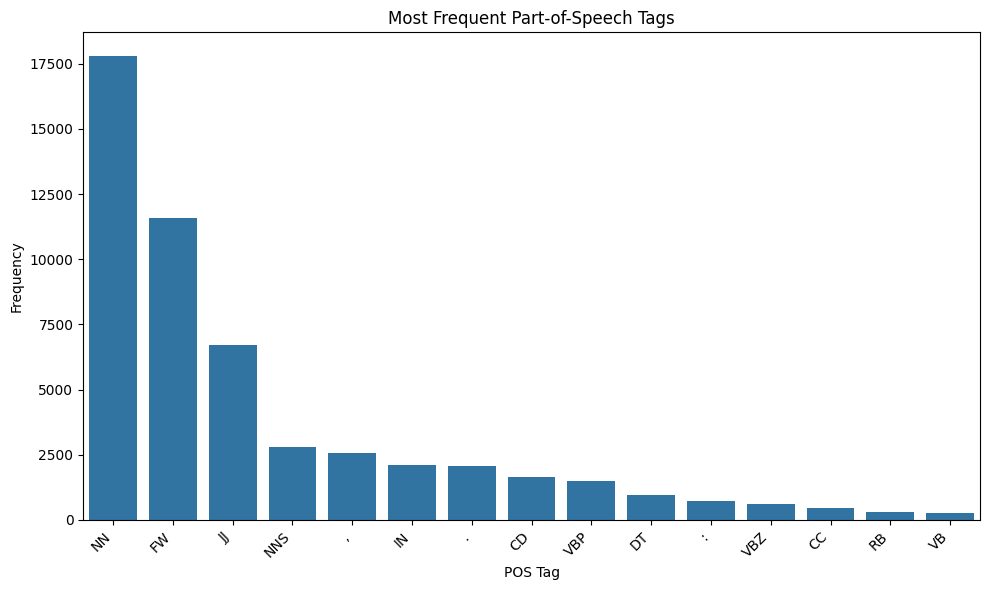

In [6]:
# POS Tagging
pos_tags = nltk.pos_tag(words) # Use 'words' (not filtered_words) to get POS for all words
pos_tag_counts = Counter(tag for word, tag in pos_tags)
most_common_pos_tags = pos_tag_counts.most_common(15)

print("\n--- Part-of-Speech Tag Frequency ---")
for tag, freq in most_common_pos_tags:
    print(f"{tag}: {freq}")

# Visualization: Bar Chart of POS Tag Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=[tag for tag, freq in most_common_pos_tags], y=[freq for tag, freq in most_common_pos_tags])
plt.title('Most Frequent Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.4 Concordance Analysis (Key Word in Context - KWIC)

Shows occurrences of a specific word with its surrounding context.

In [7]:
from nltk.text import Text

# Concordance Analysis
text_nltk = Text(words)

def display_concordance(word, num_lines=10):
    """Displays concordance for a given word."""
    print(f"\n--- Concordance for '{word}' ---")
    text_nltk.concordance(word, lines=num_lines)

# Example: Display concordance for 'data' (you can change this word)
display_concordance('mxico')
display_concordance('mujeres')

# Visualization: Simple "Concordance-like" bar chart for context words
def visualize_kwic_context(target_word, window_size=5, top_n=10):
    context_words = []
    for i, word in enumerate(words):
        if word == target_word:
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            context_words.extend([w for w in words[start:end] if w != target_word and w not in stop_words])

    if not context_words:
        print(f"'{target_word}' not found in the text for context visualization.")
        return

    context_freq = Counter(context_words)
    most_common_context = context_freq.most_common(top_n)

    if not most_common_context:
        print(f"No common context words found for '{target_word}'.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word for word, freq in most_common_context], y=[freq for word, freq in most_common_context])
    plt.title(f"Top {top_n} Context Words for '{target_word}'")
    plt.xlabel('Context Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example visualization for 'data'
visualize_kwic_context('data')
visualize_kwic_context('analysis')


--- Concordance for 'mxico' ---
no matches

--- Concordance for 'mujeres' ---
Displaying 10 of 184 matches:
ualdad sustantiva y derechos de las mujeres ............ 74 eje transversal 2 :
climático . igualdad sustantiva las mujeres tenemos derecho a la igualdad susta
d sustantiva . históricamente a las mujeres se les han negado sus derechos plen
ualdad sustantiva y derechos de las mujeres . innovación pública para el desarr
ara el bienestar nuevos : todas las mujeres de 60 a 64 años tendrán un apoyo bi
mo reconocimiento al trabajo de las mujeres mexicanas . todas las niñas y niños
diendo la herencia de encargos . 19 mujeres , indígenas y afromexicanos e innov
ad sustantiva y los derechos de las mujeres son una prioridad ineludible . no p
minación de la violencia contra las mujeres , el cierre de brechas salariales ,
sí como el acceso a la salud de las mujeres . en este horizonte , serán 150 mil
'data' not found in the text for context visualization.
'analysis' not found in the text fo

## 5.5 Collocation Analysis

Identifies words that frequently co-occur with each other.



--- Top 20 Collocations (Bigrams) ---
organizó vecinos
pequeñas medianas
vecinos resolverlo
austeridad republicana
lópez obrador
pequeños medianos
presuntamente violatorios
variación porcentual
otorgadas titulares
hechos presuntamente
términos reales
cargos elección
rezago habitacional
segundo piso
distritos riego
efecto invernadero
solicitan reciben
ahorro retiro
medianos productores
leyes generales


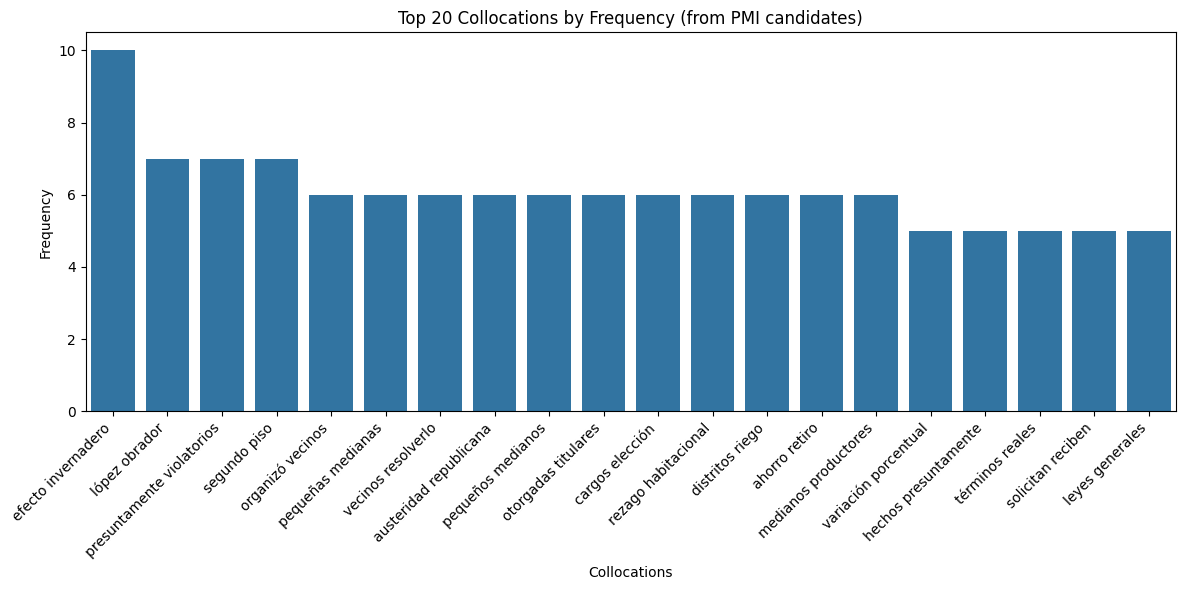

In [8]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Collocation Analysis
# Find bigrams that are statistically significant collocations
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(filtered_words)

# Filter by frequency (e.g., only consider bigrams that appear at least 5 times)
finder.apply_freq_filter(5)

# Get the top N collocations based on a scoring function (e.g., PMI - Pointwise Mutual Information)
# Other scores: nltk.collocations.likelihood_ratio, nltk.collocations.chi_sq
top_collocations = finder.nbest(bigram_measures.pmi, 20)

print("\n--- Top 20 Collocations (Bigrams) ---")
for col in top_collocations:
    print(f"{' '.join(col)}")

# Visualization: Bar Chart of Top Collocations (PMI score as an indicator)
# Note: PMI scores can be negative or very large; normalizing or just showing the collocations is common.
# For visualization, let's use a simple bar chart of their frequency, or if PMI is required,
# we would need to extract and plot the PMI values.
# For simplicity, we'll plot the frequency of the identified collocations.

collocation_freqs = []
for col in top_collocations:
    collocation_freqs.append((f"{col[0]} {col[1]}", bigram_freq[col]))

collocation_freqs.sort(key=lambda x: x[1], reverse=True) # Sort by frequency for plotting

if collocation_freqs:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[col[0] for col in collocation_freqs], y=[col[1] for col in collocation_freqs])
    plt.title('Top 20 Collocations by Frequency (from PMI candidates)')
    plt.xlabel('Collocations')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No significant collocations found for visualization based on current filters.")

# 5.6 Keyword Analysis

Identifies important keywords in the text. This often involves TF-IDF (Term Frequency-Inverse Document Frequency) or similar techniques. Since we have a single combined document, TF-IDF will show important words within that document relative to other potential documents (if we were comparing), or simply highlight relatively unique words within this text.

For a single document, simpler approaches like frequency (already done) or filtering common words are also used. For illustrative purposes, we'll use TF-IDF.


--- Top 20 Keywords (TF-IDF Scores) ---
la: 0.6679
el: 0.4261
en: 0.3064
los: 0.2289
las: 0.2107
que: 0.1840
para: 0.1793
del: 0.1544
se: 0.1054
una: 0.0845
estrategia: 0.0766
desarrollo: 0.0748
nacional: 0.0731
su: 0.0693
es: 0.0581
por: 0.0566
mujeres: 0.0540
acceso: 0.0511
méxico: 0.0511
como: 0.0508


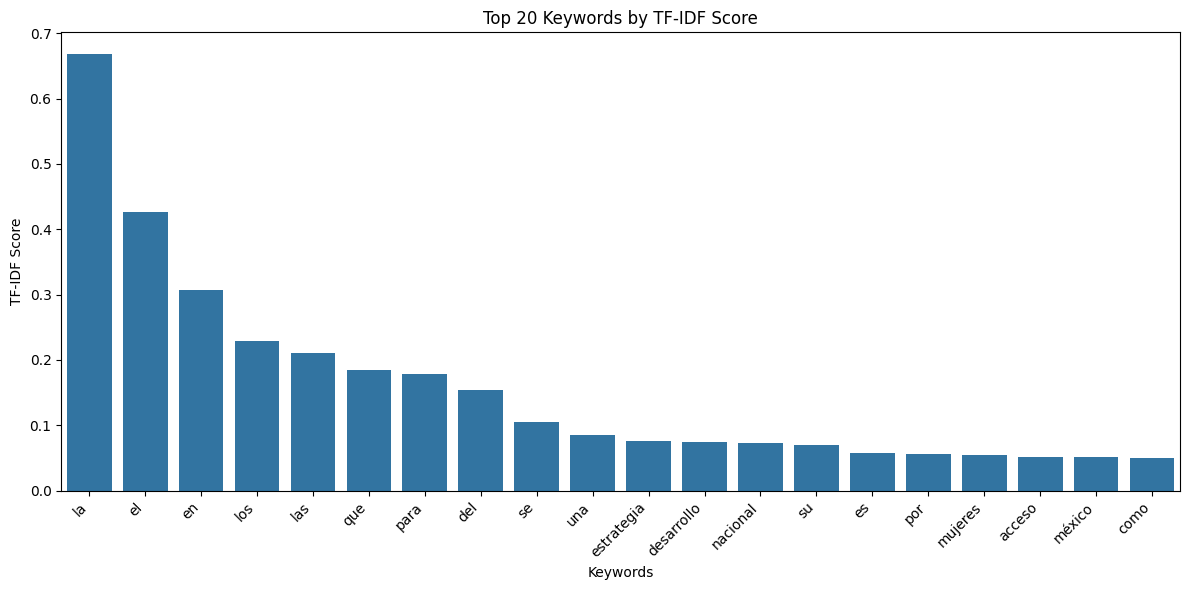

In [9]:
# Keyword Analysis (using TF-IDF for illustrative purposes, typically for multiple documents)
# For a single document, high TF-IDF indicates a word that is frequent in this document
# and relatively rare in a hypothetical corpus (or simply frequent in this one).

# TfidfVectorizer expects a list of documents, so we pass our combined text as a single-element list
vectorizer = TfidfVectorizer(stop_words='english', max_features=50) # Limit to top 50
tfidf_matrix = vectorizer.fit_transform([combined_text])
feature_names = vectorizer.get_feature_names_out()

tfidf_scores = tfidf_matrix.toarray().flatten()
keyword_scores = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

print("\n--- Top 20 Keywords (TF-IDF Scores) ---")
for keyword, score in keyword_scores[:20]:
    print(f"{keyword}: {score:.4f}")

# Visualization: Bar Chart of Top Keywords by TF-IDF Score
keywords_to_plot = keyword_scores[:20]
if keywords_to_plot:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[kw for kw, score in keywords_to_plot], y=[score for kw, score in keywords_to_plot])
    plt.title('Top 20 Keywords by TF-IDF Score')
    plt.xlabel('Keywords')
    plt.ylabel('TF-IDF Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No keywords found for visualization.")

# 5.7 Dispersion Analysis (Whelk Analysis)

Shows the distribution of specific words throughout the text.



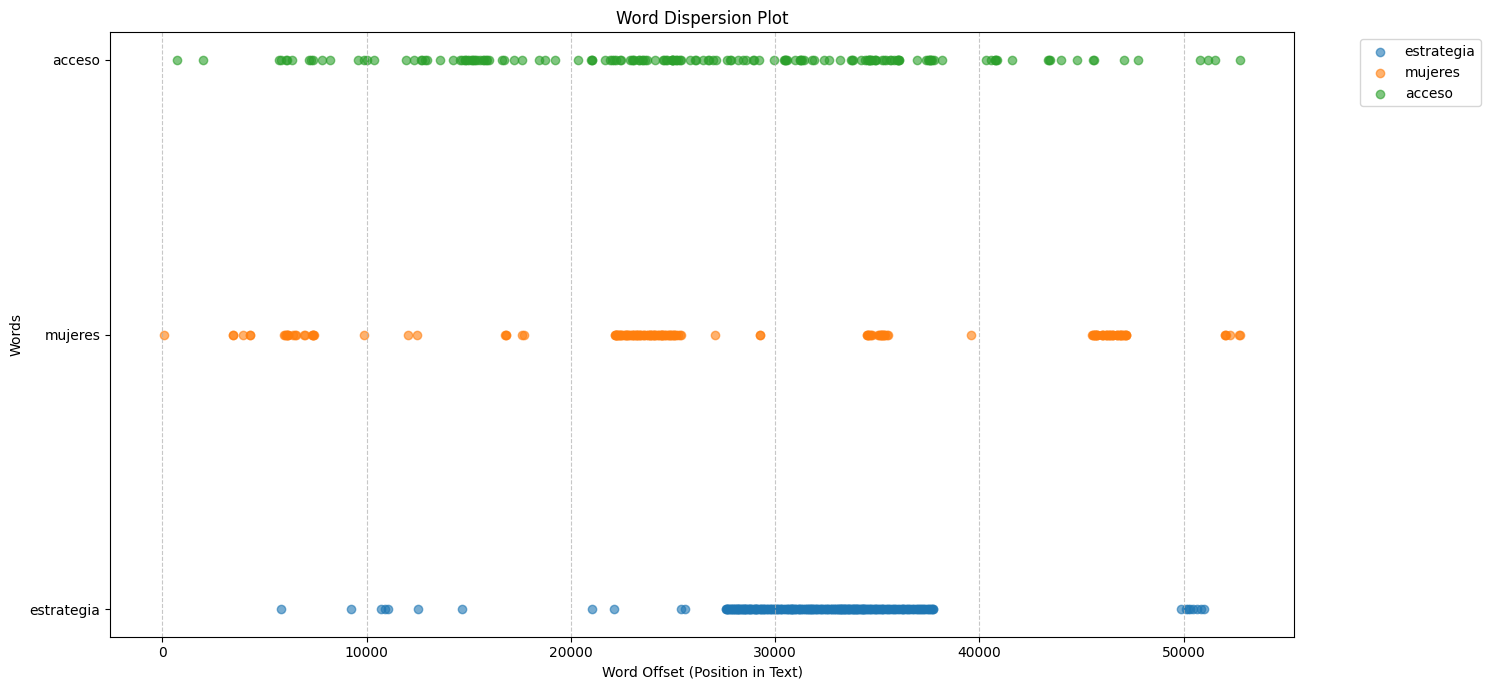

In [10]:
# Dispersion Analysis
def plot_word_dispersion(text_words, words_to_track):
    """Plots the dispersion of specified words throughout the text."""
    text_len = len(text_words)
    word_indices = {word: [] for word in words_to_track}

    for i, word in enumerate(text_words):
        if word in words_to_track:
            word_indices[word].append(i)

    plt.figure(figsize=(15, 7))
    for i, word in enumerate(words_to_track):
        y_coords = [i] * len(word_indices[word])
        plt.scatter(word_indices[word], y_coords, label=word, alpha=0.6)

    plt.yticks(range(len(words_to_track)), words_to_track)
    plt.xlabel('Word Offset (Position in Text)')
    plt.ylabel('Words')
    plt.title('Word Dispersion Plot')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example: Choose some keywords or frequent words to track
words_to_track = ['lpez', 'mxico', 'estrategia', 'mujeres', 'acceso']
# Ensure these words are present in the 'words' list (lowercase)
words_to_track_filtered = [word for word in words_to_track if word in set(words)]

if words_to_track_filtered:
    plot_word_dispersion(words, words_to_track_filtered)
else:
    print("None of the specified words were found in the text for dispersion analysis.")

## 5.8 Lexical Richness/Diversity Measures

Quantifies the variety of vocabulary in the text.



--- Lexical Richness/Diversity Measures ---
Total Words (Tokens): 52815
Unique Words (Types): 5763
Type-Token Ratio (TTR): 0.1091
Filtered Words (Tokens - no stopwords/non-alphanumeric): 26491
Unique Filtered Words (Types): 4919
Filtered Type-Token Ratio (TTR): 0.1857


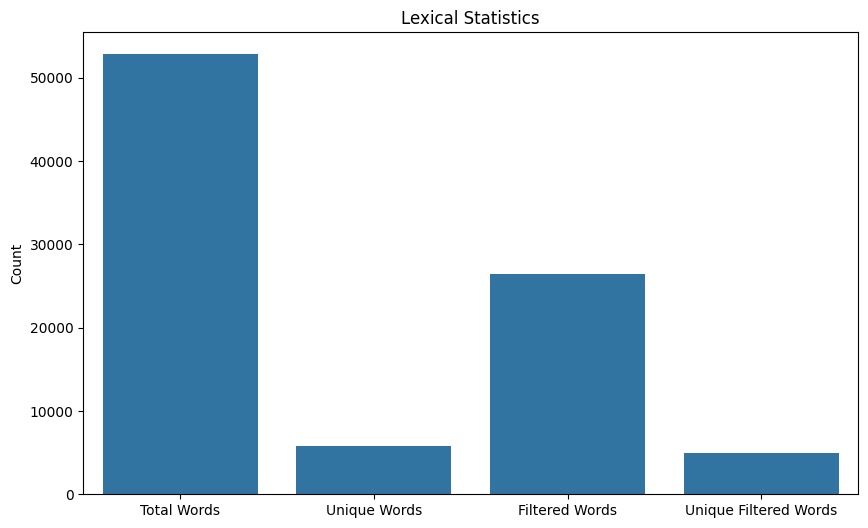

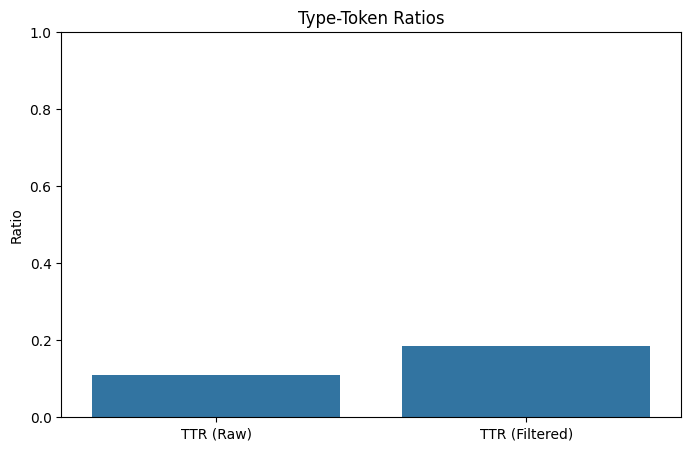

In [11]:
# Lexical Richness/Diversity Measures
num_words = len(words)
num_unique_words = len(set(words))
num_filtered_words = len(filtered_words)
num_unique_filtered_words = len(set(filtered_words))

# Type-Token Ratio (TTR)
ttr = num_unique_words / num_words if num_words > 0 else 0
filtered_ttr = num_unique_filtered_words / num_filtered_words if num_filtered_words > 0 else 0

print(f"\n--- Lexical Richness/Diversity Measures ---")
print(f"Total Words (Tokens): {num_words}")
print(f"Unique Words (Types): {num_unique_words}")
print(f"Type-Token Ratio (TTR): {ttr:.4f}")
print(f"Filtered Words (Tokens - no stopwords/non-alphanumeric): {num_filtered_words}")
print(f"Unique Filtered Words (Types): {num_unique_filtered_words}")
print(f"Filtered Type-Token Ratio (TTR): {filtered_ttr:.4f}")

# Moving-Average Type-Token Ratio (MATTR) or Guiraud's Index for better comparison across texts
# For simplicity, we'll focus on TTR and its filtered version.

# Visualization: Bar Chart for TTR
metrics = ['Total Words', 'Unique Words', 'Filtered Words', 'Unique Filtered Words']
values = [num_words, num_unique_words, num_filtered_words, num_unique_filtered_words]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values)
plt.title('Lexical Statistics')
plt.ylabel('Count')
plt.show()

metrics_ttr = ['TTR (Raw)', 'TTR (Filtered)']
values_ttr = [ttr, filtered_ttr]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics_ttr, y=values_ttr)
plt.title('Type-Token Ratios')
plt.ylabel('Ratio')
plt.ylim(0, 1)
plt.show()

## 5.9 Readability and Complexity Analysis

Estimates how easy or difficult the text is to read.


--- Readability and Complexity Analysis ---
Flesch-Kincaid Grade Level: 19.33
Automated Readability Index (ARI): 16.06
Average Sentence Length: 21.61 words
Average Syllables per Word: 2.24


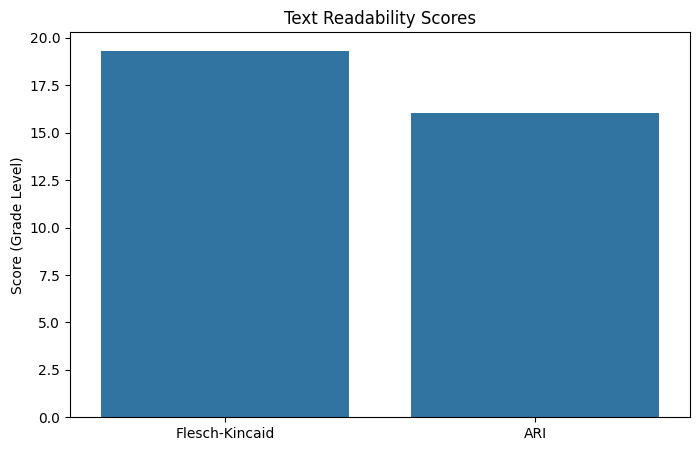

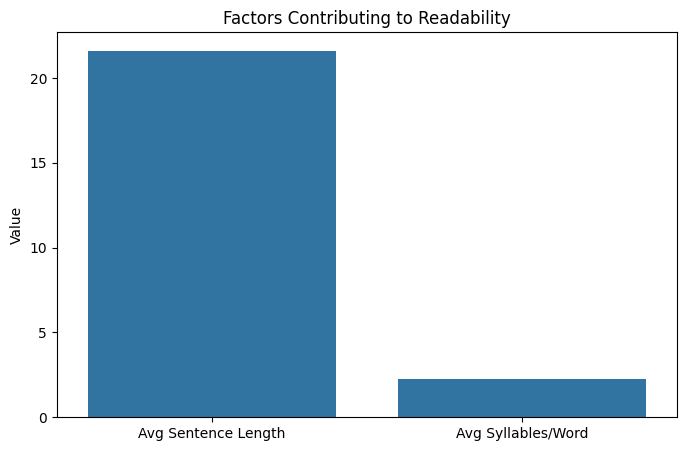

In [12]:
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize, word_tokenize
import math

# Readability and Complexity Analysis
# Using Flesch-Kincaid Grade Level and Automated Readability Index (ARI)
# Requires average sentence length and average syllables per word.
# Syllable counting is complex; for simplicity, we'll use a rough estimate or external library if available.
# Textstat is a good external library, but we'll try to implement basic formulas.

def count_syllables_simple(word):
    # A very basic syllable counter (can be inaccurate for complex words)
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if word.endswith("le"):
        count += 1
    if count == 0:
        count = 1 # Every word has at least one syllable
    return count

def calculate_readability(text):
    sentences_list = sent_tokenize(text)
    words_list = word_tokenize(text)
    words_filtered_for_readability = [word for word in words_list if word.isalpha()]

    num_sentences = len(sentences_list)
    num_words = len(words_filtered_for_readability)
    if num_words == 0 or num_sentences == 0:
        return {'flesch_kincaid': 0, 'ari': 0, 'avg_sentence_length': 0, 'avg_syllables_per_word': 0}

    total_syllables = sum(count_syllables_simple(word) for word in words_filtered_for_readability)
    avg_sentence_length = num_words / num_sentences
    avg_syllables_per_word = total_syllables / num_words

    # Flesch-Kincaid Grade Level: 0.39 * (words/sentences) + 11.8 * (syllables/words) - 15.59
    flesch_kincaid = 0.39 * avg_sentence_length + 11.8 * avg_syllables_per_word - 15.59

    # Automated Readability Index (ARI): 4.71 * (characters/words) + 0.5 * (words/sentences) - 21.43
    # For ARI, we need character count.
    total_characters = sum(len(word) for word in words_filtered_for_readability)
    avg_chars_per_word = total_characters / num_words

    ari = 4.71 * avg_chars_per_word + 0.5 * avg_sentence_length - 21.43

    return {
        'flesch_kincaid': max(0, flesch_kincaid), # Grade level shouldn't be negative
        'ari': max(0, ari), # ARI shouldn't be negative
        'avg_sentence_length': avg_sentence_length,
        'avg_syllables_per_word': avg_syllables_per_word
    }

readability_scores = calculate_readability(combined_text)

print("\n--- Readability and Complexity Analysis ---")
print(f"Flesch-Kincaid Grade Level: {readability_scores['flesch_kincaid']:.2f}")
print(f"Automated Readability Index (ARI): {readability_scores['ari']:.2f}")
print(f"Average Sentence Length: {readability_scores['avg_sentence_length']:.2f} words")
print(f"Average Syllables per Word: {readability_scores['avg_syllables_per_word']:.2f}")

# Visualization: Bar Chart of Readability Scores
readability_metrics = ['Flesch-Kincaid', 'ARI']
readability_values = [readability_scores['flesch_kincaid'], readability_scores['ari']]

plt.figure(figsize=(8, 5))
sns.barplot(x=readability_metrics, y=readability_values)
plt.title('Text Readability Scores')
plt.ylabel('Score (Grade Level)')
plt.show()

# Visualization: Bar Chart of contributing factors
contributing_metrics = ['Avg Sentence Length', 'Avg Syllables/Word']
contributing_values = [readability_scores['avg_sentence_length'], readability_scores['avg_syllables_per_word']]

plt.figure(figsize=(8, 5))
sns.barplot(x=contributing_metrics, y=contributing_values)
plt.title('Factors Contributing to Readability')
plt.ylabel('Value')
plt.show()

## 5.10 Sentiment and Emotion Analysis (Initial Pass)

Performs a basic sentiment analysis using TextBlob. More advanced emotion analysis would typically require a specialized lexicon or a pre-trained model.


--- Sentiment Analysis (TextBlob) ---
Polarity: -0.03 (ranges from -1.0 to 1.0, where 1.0 is positive and -1.0 is negative)
Subjectivity: 0.40 (ranges from 0.0 to 1.0, where 0.0 is objective and 1.0 is subjective)
Overall Sentiment: Neutral


/tmp/ipykernel_55472/813398936.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_metrics, y=sentiment_values, palette=['skyblue', 'lightcoral'])


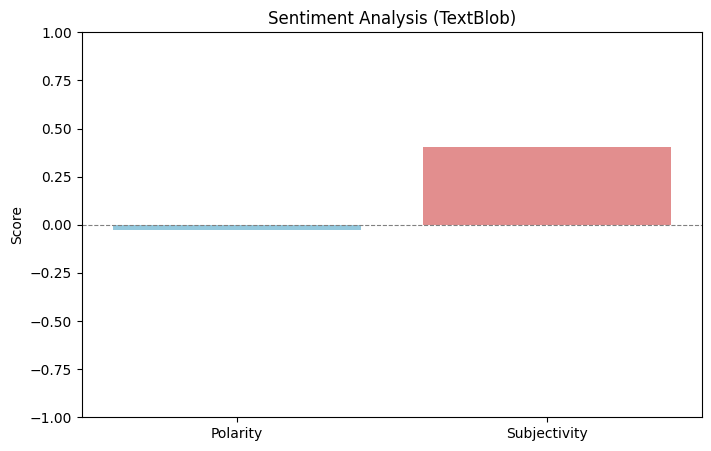

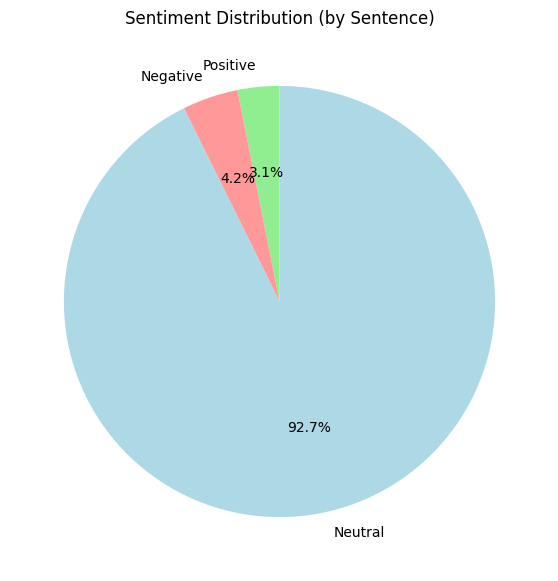

In [13]:
# Sentiment Analysis using TextBlob
blob = TextBlob(combined_text)
sentiment = blob.sentiment

print("\n--- Sentiment Analysis (TextBlob) ---")
print(f"Polarity: {sentiment.polarity:.2f} (ranges from -1.0 to 1.0, where 1.0 is positive and -1.0 is negative)")
print(f"Subjectivity: {sentiment.subjectivity:.2f} (ranges from 0.0 to 1.0, where 0.0 is objective and 1.0 is subjective)")

# Interpret sentiment
if sentiment.polarity > 0.1:
    sentiment_label = "Positive"
elif sentiment.polarity < -0.1:
    sentiment_label = "Negative"
else:
    sentiment_label = "Neutral"

print(f"Overall Sentiment: {sentiment_label}")

# Visualization: Bar Chart for Polarity and Subjectivity
sentiment_metrics = ['Polarity', 'Subjectivity']
sentiment_values = [sentiment.polarity, sentiment.subjectivity]

plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_metrics, y=sentiment_values, palette=['skyblue', 'lightcoral'])
plt.title('Sentiment Analysis (TextBlob)')
plt.ylabel('Score')
plt.ylim(-1.0, 1.0) # Polarity ranges from -1 to 1, Subjectivity from 0 to 1
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.show()

# Simple pie chart for sentiment distribution (if we had more granularity)
# For a single polarity score, we can just visualize the score itself.
# To show "Positive/Negative/Neutral" distribution, we'd need to classify sentences.

sentence_sentiments = [TextBlob(sentence).sentiment.polarity for sentence in sentences]
positive_sentences = sum(1 for s in sentence_sentiments if s > 0.1)
negative_sentences = sum(1 for s in sentence_sentiments if s < -0.1)
neutral_sentences = sum(1 for s in sentence_sentiments if -0.1 <= s <= 0.1)

sentiment_counts = {
    'Positive': positive_sentences,
    'Negative': negative_sentences,
    'Neutral': neutral_sentences
}

if sum(sentiment_counts.values()) > 0:
    plt.figure(figsize=(7, 7))
    plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['#90ee90', '#ff9999', '#add8e6'])
    plt.title('Sentiment Distribution (by Sentence)')
    plt.show()
else:
    print("Not enough sentences to generate sentiment distribution.")

## 5.11 Topic Modeling (Probabilistic)

Uses Latent Dirichlet Allocation (LDA) to discover abstract "topics" in the text.


--- Topic Modeling (LDA) with 5 Topics ---
Topic 0: 0.011*"mujeres" + 0.011*"bienestar" + 0.011*"desarrollo" + 0.010*"acceso" + 0.008*"estrategia"
Topic 1: 0.027*"méxico" + 0.022*"plan" + 0.017*"sectores" + 0.014*"país" + 0.013*"crecimiento"
Topic 2: 0.017*"derechos" + 0.016*"propuestas" + 0.014*"así" + 0.013*"indígenas" + 0.012*"pnd"
Topic 3: 0.065*"programa" + 0.058*"nacional" + 0.024*"desarrollo" + 0.018*"eje" + 0.015*"especial"
Topic 4: 0.028*"productiva" + 0.015*"país" + 0.013*"regiones" + 0.012*"industrial" + 0.012*"expansión"


/tmp/ipykernel_55472/3698781610.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=weights, ax=axes[i], palette='viridis')
/tmp/ipykernel_55472/3698781610.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45, ha='right')
/tmp/ipykernel_55472/3698781610.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=weights, ax=axes[i], palette='viridis')
/tmp/ipykernel_55472/3698781610.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, r

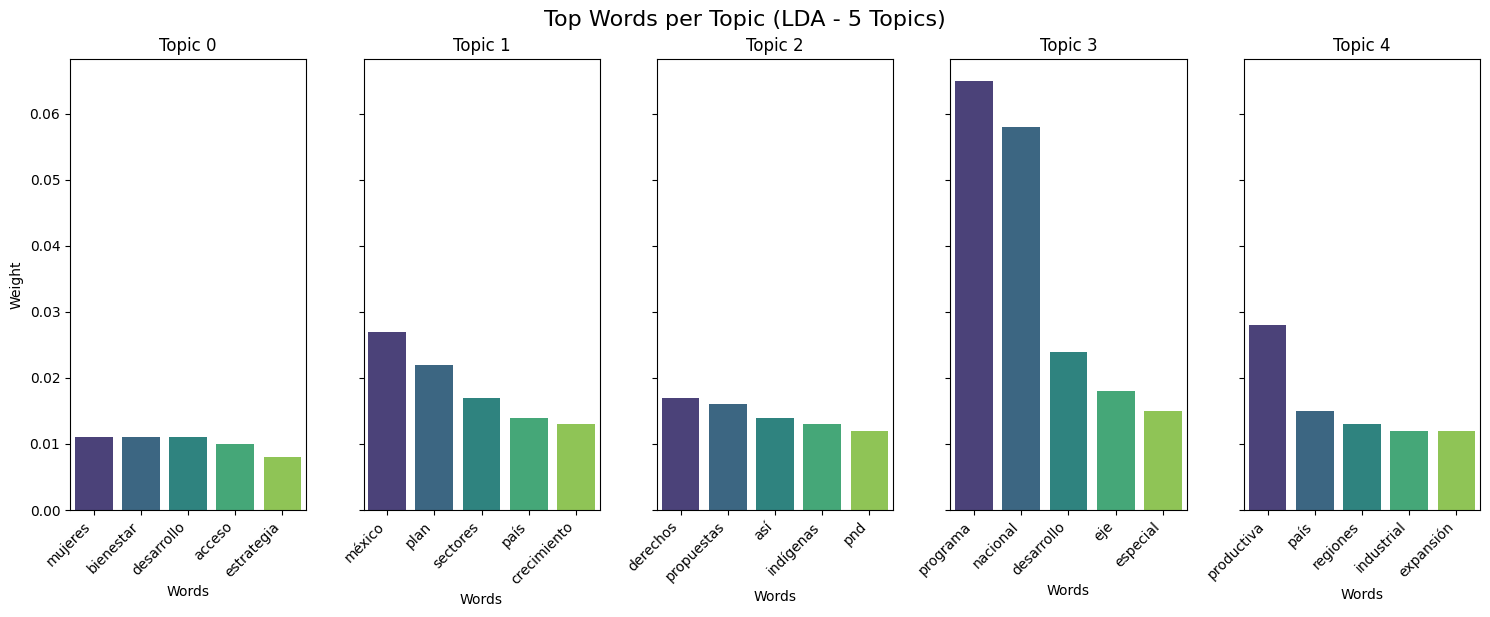

In [14]:
# Topic Modeling (LDA)
# Prepare data for LDA
texts_for_lda = [[word for word in word_tokenize(sentence) if word.isalnum() and word not in stop_words] for sentence in sentences if len(word_tokenize(sentence)) > 0]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(texts_for_lda)
corpus = [dictionary.doc2bow(text) for text in texts_for_lda]

# Train the LDA model
num_topics = 5 # You can adjust the number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=1)

print(f"\n--- Topic Modeling (LDA) with {num_topics} Topics ---")
topics = lda_model.print_topics(num_words=5) # Show top 5 words per topic
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

# Visualization: Bar Chart of Top Words per Topic
fig, axes = plt.subplots(ncols=num_topics, figsize=(15, 6), sharey=True)
axes = axes.flatten()

for i, topic in enumerate(topics):
    topic_id, topic_words_str = topic
    # Parse the topic words string (e.g., '0.050*"word1" + 0.040*"word2"')
    words_weights = re.findall(r'(\d+\.\d+)\*"(\w+)"', topic_words_str)
    words = [word for weight, word in words_weights]
    weights = [float(weight) for weight, word in words_weights]

    if words:
        sns.barplot(x=words, y=weights, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Topic {topic_id}')
        axes[i].set_xlabel('Words')
        axes[i].set_ylabel('Weight')
        
        # --- THE FIX IS HERE ---
        # Instead of axes[i].tick_params(), use plt.xticks() or axes[i].set_xticklabels()
        # The 'rotation' parameter can stay in tick_params, but 'ha' should be in the xticks call.
        
        # A more robust and cleaner way is to use set_xticklabels
        axes[i].set_xticklabels(words, rotation=45, ha='right')
        
        # Or, if you want to keep the tick_params call for other parameters,
        # a simpler fix is to just move the rotation and use the keyword in set_xticklabels
        # axes[i].tick_params(axis='x', rotation=45) # Keep other parameters here if needed
        # axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right') # This is also an option
        
        # My recommendation is to combine the logic for both in a single call for clarity.
        # So, the final code block looks like this:
        # axes[i].set_xticklabels(words, rotation=45, ha='right') # This is clean and direct.
    else:
        axes[i].set_title(f'Topic {topic_id} (No words found)')
        axes[i].text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.suptitle(f'Top Words per Topic (LDA - {num_topics} Topics)', y=1.02, fontsize=16)
plt.show()

## 5.12 Named Entity Recognition (NER) and Entity Frequency

Identifies and categorizes named entities (e.g., persons, organizations, locations). Requires spaCy.


--- Named Entity Recognition (NER) Label Frequency ---
PERSON: 2889
ORG: 2017
GPE: 1204
CARDINAL: 989
DATE: 233
FAC: 176
PERCENT: 151
NORP: 85
PRODUCT: 29
QUANTITY: 25

--- Top 10 PERSON Entities ---
el avance: 66
para el: 56
descripción: 53
de género: 15
de la: 13
de las: 13
para la: 12
de méxico: 12
la población: 11
económicos: 11

--- Top 10 ORG Entities ---
un: 275
de los: 46
línea base meta: 36
el derecho: 25
de la: 20
como: 16
de las: 13
al: 12
el territorio: 11
asimismo: 10

--- Top 10 GPE Entities ---
la: 100
inegi: 37
las: 28
el desarrollo: 24
las personas: 15
la seguridad: 13
tecnológica: 12
los derechos: 10
los servicios: 10
básicos: 10


/tmp/ipykernel_55472/1833387466.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='coolwarm')


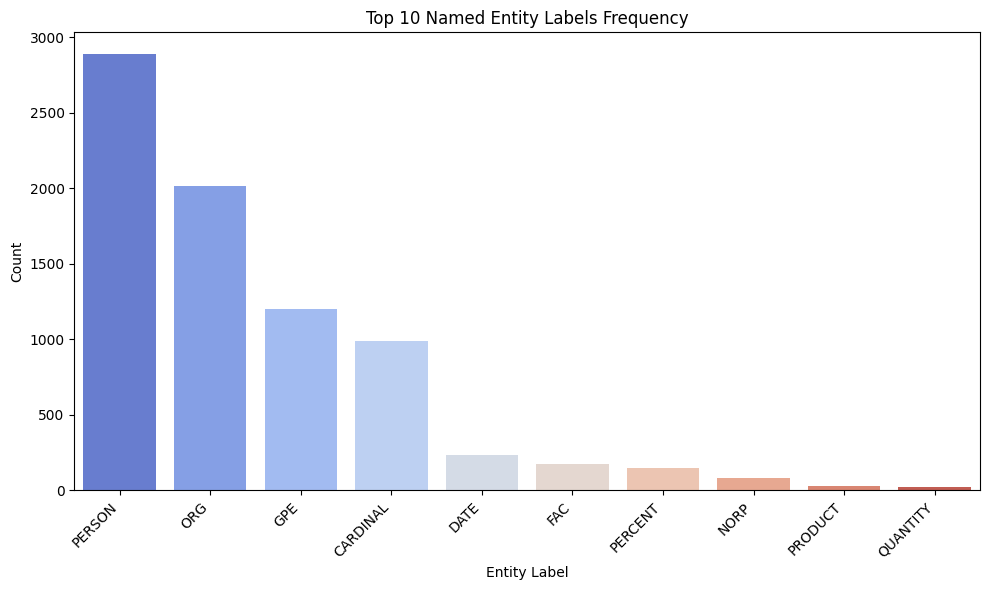

/tmp/ipykernel_55472/1833387466.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=counts, palette='Paired')


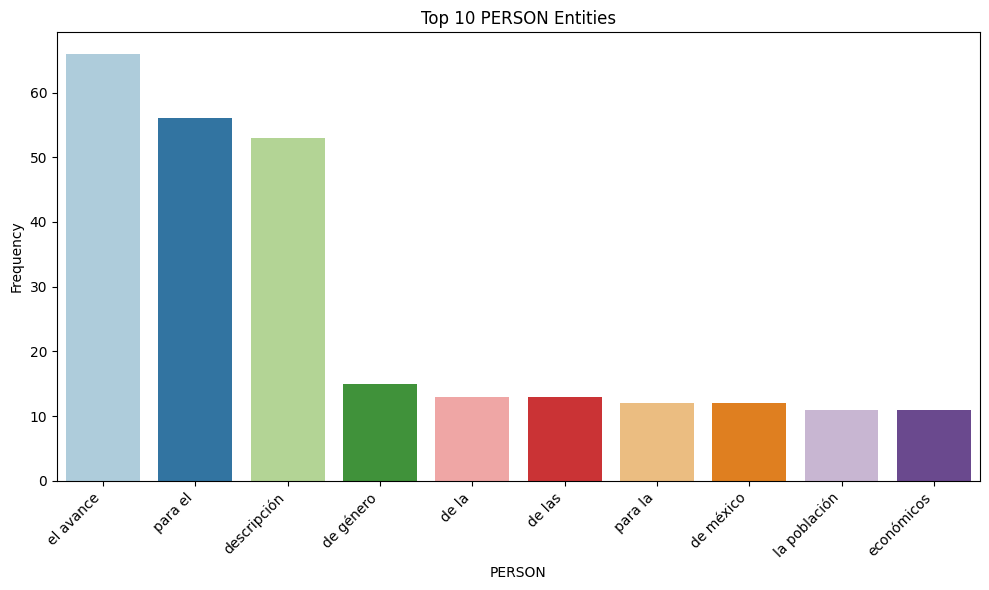

/tmp/ipykernel_55472/1833387466.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=counts, palette='Paired')


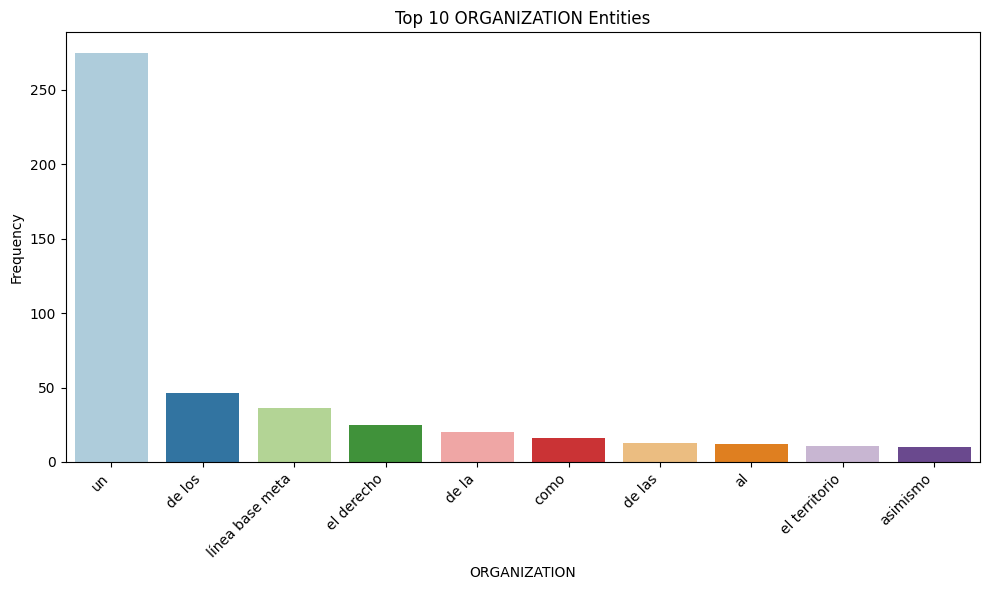

/tmp/ipykernel_55472/1833387466.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=counts, palette='Paired')


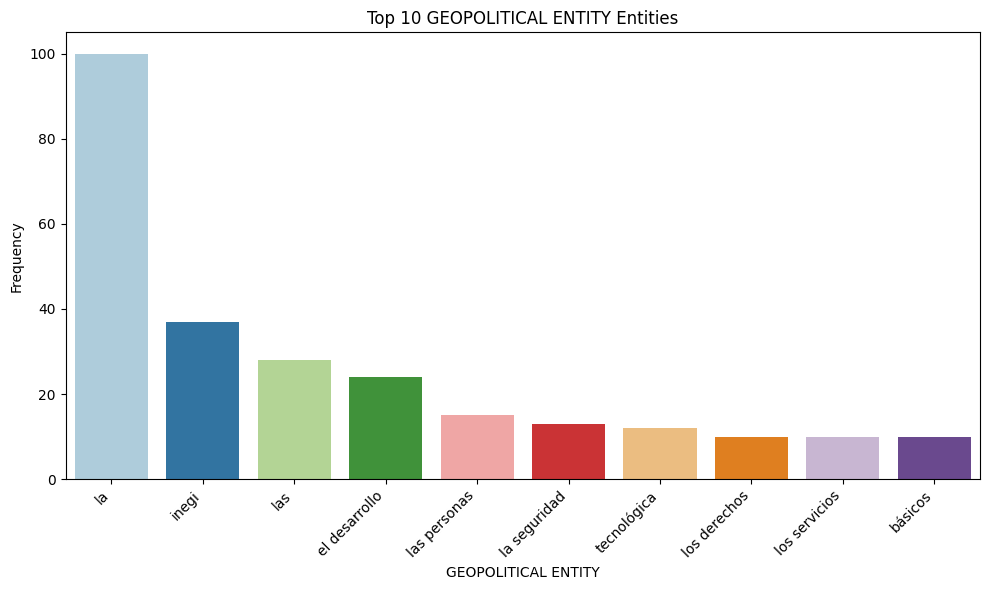

In [15]:
import spacy

# Load the small English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for spaCy...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# NER
doc = nlp(combined_text)

# Extract entities and their labels
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Count frequency of each entity label
entity_label_counts = Counter(label for text, label in entities)
print("\n--- Named Entity Recognition (NER) Label Frequency ---")
for label, count in entity_label_counts.most_common(10):
    print(f"{label}: {count}")

# Count frequency of specific entity types (e.g., PERSON, ORG, GPE)
person_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "PERSON")
org_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "ORG")
gpe_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "GPE") # Geopolitical Entity (countries, cities, states)

print("\n--- Top 10 PERSON Entities ---")
for entity, count in person_entities.most_common(10):
    print(f"{entity}: {count}")

print("\n--- Top 10 ORG Entities ---")
for entity, count in org_entities.most_common(10):
    print(f"{entity}: {count}")

print("\n--- Top 10 GPE Entities ---")
for entity, count in gpe_entities.most_common(10):
    print(f"{entity}: {count}")

# Visualization: Bar Chart of Top Entity Labels
if entity_label_counts:
    labels = [label for label, count in entity_label_counts.most_common(10)]
    counts = [count for label, count in entity_label_counts.most_common(10)]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels, y=counts, palette='coolwarm')
    plt.title('Top 10 Named Entity Labels Frequency')
    plt.xlabel('Entity Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No entities found for visualization.")


# Visualization: Bar Charts for specific entity types (e.g., PERSON, ORG)
def plot_top_entities(entity_counter, title, num_to_plot=10):
    if entity_counter:
        entities_to_plot = entity_counter.most_common(num_to_plot)
        names = [name for name, count in entities_to_plot]
        counts = [count for name, count in entities_to_plot]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=names, y=counts, palette='Paired')
        plt.title(f'Top {num_to_plot} {title} Entities')
        plt.xlabel(title)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No {title} entities found for visualization.")

plot_top_entities(person_entities, 'PERSON')
plot_top_entities(org_entities, 'ORGANIZATION')
plot_top_entities(gpe_entities, 'GEOPOLITICAL ENTITY')